In [1]:
import pandas as pd
import numpy as np
import time
import multiprocessing as mp
from dask.dataframe import from_pandas
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 100)

# 1. Read Data

In [2]:
%%time
# read data
data = pd.read_csv('onlinefraud.csv')

CPU times: user 7.29 s, sys: 1.81 s, total: 9.09 s
Wall time: 9.11 s


In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.shape

(6362620, 11)

In [5]:
data = data.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)

<AxesSubplot:>

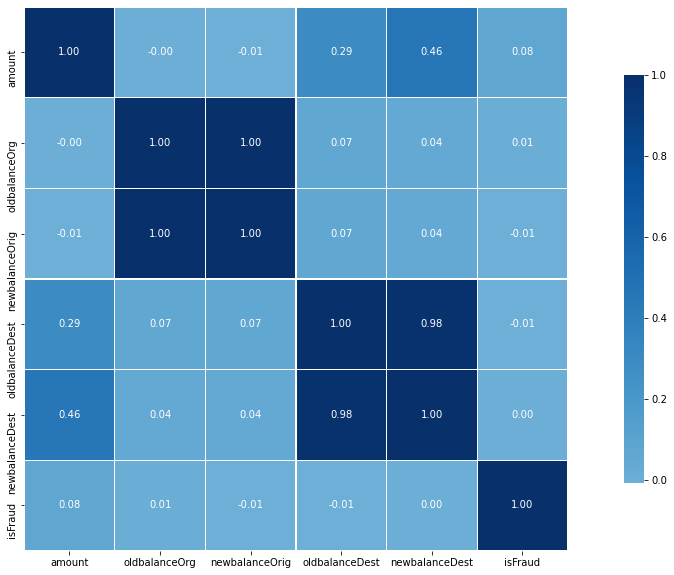

In [6]:
plt.figure(figsize = [20,10])   
sns.heatmap(data = data.corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  
          fmt='.2f',    
           cmap = 'Blues',   
           linewidths = .3,  
           cbar_kws={"shrink": .75})

# 2. Create Metadata

In [7]:
def meta(dt,col):
    
    # Create an empty list
    data_list = []
        
    #role ==> target|features
    if col == 'isFraud':
        role = 'target'
    else:
        role = 'feature'
        
    #level ==> binary|nominal|ordinal|interval|ratio
    if col == 'isFraud':
        level = 'binary'
    elif 'name' in col or 'type' in col:
        level = 'nominal'
    elif dt[col].dtype == 'float64':
        level = 'interval'
    elif dt[col].dtype == 'int64':
        level = 'ordinal'
            
    #dtype ==> int | float | object...
    dtype = dt[col].dtype
        
    #unique_num/cardinality ==> Number of unique values
    #Disregard id, target, continuous features
    if col == 'isFraud' or dt[col].dtype == 'float64':
        cardinality = 'Ignore'
    else:
        #Exclude missing values
        cardinality = dt[dt[col]!=""][col].nunique()
        
    #missing_num ==> Number of missing values
    missing = dt[dt[col]==""][col].count()
 
    #missing_percent ==> Percentage of missing values
    missing_percent = f'{missing}({round(missing*100/len(dt),2)}%)'

    #imputation ==> Methods for filling in missing values
    if dt[dt[col]==-1][col].count()/dt.shape[0] > 0.4:
        imputation = 'remove'
    elif dt[dt[col]==-1][col].count() == 0:
        imputation = 'No Missing'
    #continuous features - interval/ratio
    elif dt[col].dtype == 'float64':
        imputation = ('mode','median','mean')
    # nominal/binary/（Disregard id and target for now）
    elif 'name' in col or 'type' in col:
        imputation = ('mode')
    # ordinal
    elif dt[col].dtype == 'int64':
        imputation = ('mode','median')
        
    #Store each attribute of each column by dictionary
    cols = {'colname':col
            ,'role':role
            ,'level':level
            ,'dtype':dtype
            ,'cardinality':cardinality
            ,'missing':missing
            ,'missing_percent':missing_percent
            ,'imputation':imputation
            }
        
    #Store each attribute of each column in the empty list (including column names)
    data_list.append(cols)
    
    #Convert list to df
    metadata = pd.DataFrame(data_list, columns=['colname','role','level','dtype','cardinality','missing','missing_percent','imputation'])
    #Set the index of df to the variable name
    metadata.set_index('colname', inplace=True)
    return metadata

### 2.1 Creating metadata (serial)

In [8]:
start_time_0 = time.time()
for col in data.columns:
    metadata = meta(data,col)
    print(metadata,'\n','-'*80)
elapsed_time_0 = time.time()-start_time_0
print(elapsed_time_0)

            role    level   dtype  cardinality  missing missing_percent  imputation
colname                                                                            
type     feature  nominal  object            5        0         0(0.0%)  No Missing 
 --------------------------------------------------------------------------------
            role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                             
amount   feature  interval  float64      Ignore        0         0(0.0%)  No Missing 
 --------------------------------------------------------------------------------
                  role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                                   
oldbalanceOrg  feature  interval  float64      Ignore        0         0(0.0%)  No Missing 
 ----------------------------------------------------

### 2.2 Create metadata (in parallel - use pool() and vs.CPUs)

In [9]:
for i in [1,2,4,8]:
    pool = mp.Pool(i)
    t = time.time()
    metadata = [pool.apply(meta,args=(data,col)) for col in data.columns]
    print(metadata,'\n','-'*80)
    elapsed_time = time.time()-t
    pool.close()
    print(f'Parallel execution time - using pool({i}):', elapsed_time, '\n')

[            role    level   dtype  cardinality  missing missing_percent  imputation
colname                                                                            
type     feature  nominal  object            5        0         0(0.0%)  No Missing,             role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                             
amount   feature  interval  float64      Ignore        0         0(0.0%)  No Missing,                   role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                                   
oldbalanceOrg  feature  interval  float64      Ignore        0         0(0.0%)  No Missing,                    role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                                    
newbalanceOrig  feature  interva

### 2.3 Create metadata (in parallel - use Process())

In [10]:
from multiprocessing import Process,Queue

# split work into 2 processes
q = Queue()
processes = 2
def split(columns,n):
    col_list = []
    for col in columns:
        col_list.append(col)
        split_list = [col_list[i:i + n] for i in range(0, len(col_list), n)]
    return split_list
split_cols = split(data.columns,int(len(data.columns)/processes))

t = time.time()
for cols in split_cols:
    p = Process(target=meta,args = (data,pd.Series(cols).all(),))
    p.start()
    q.put(metadata)
for cols in split_cols:
    p.join()
print(q.get(),'\n')
print('Parallel execution time - using process:', time.time()-t)

[            role    level   dtype  cardinality  missing missing_percent  imputation
colname                                                                            
type     feature  nominal  object            5        0         0(0.0%)  No Missing,             role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                             
amount   feature  interval  float64      Ignore        0         0(0.0%)  No Missing,                   role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                                   
oldbalanceOrg  feature  interval  float64      Ignore        0         0(0.0%)  No Missing,                    role     level    dtype cardinality  missing missing_percent  imputation
colname                                                                                    
newbalanceOrig  feature  interva

# 3. Feature Engineering

### 3.1 pandas

In [11]:
%%time
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = "ignore",sparse=False)
# Use oneHot encoding for the 'type' variable
type_enc = enc.fit_transform(data['type'].values.reshape(-1, 1))
data = pd.concat([data,pd.DataFrame(type_enc)],axis=1)
data.rename(columns={0:'type_CASH_IN',1:'type_CASH_OUT',2:'type_DEBIT',3:'type_PAYMENT',4:'type_TRANSFER'},inplace=True)
data = data.drop('type',axis=1)

CPU times: user 2.18 s, sys: 1.81 s, total: 3.99 s
Wall time: 4.04 s


In [12]:
%%time
# Add two new features: the difference between the old balance and the new balance
data['orig_balance_diff'] = data.oldbalanceOrg - data.newbalanceOrig
data['dest_balance_diff'] = data.oldbalanceDest - data.newbalanceDest
data = data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)

CPU times: user 622 ms, sys: 1.14 s, total: 1.76 s
Wall time: 1.76 s


In [13]:
data

,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_diff,dest_balance_diff
0,9839.64,0,0.0,0.0,0.0,1.0,0.0,9839.64,0.00
1,1864.28,0,0.0,0.0,0.0,1.0,0.0,1864.28,0.00
2,181.00,1,0.0,0.0,0.0,0.0,1.0,181.00,0.00
3,181.00,1,0.0,1.0,0.0,0.0,0.0,181.00,21182.00
4,11668.14,0,0.0,0.0,0.0,1.0,0.0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...
6362615,339682.13,1,0.0,1.0,0.0,0.0,0.0,339682.13,-339682.13
6362616,6311409.28,1,0.0,0.0,0.0,0.0,1.0,6311409.28,0.00
6362617,6311409.28,1,0.0,1.0,0.0,0.0,0.0,6311409.28,-6311409.27
6362618,850002.52,1,0.0,0.0,0.0,0.0,1.0,850002.52,0.00


<AxesSubplot:>

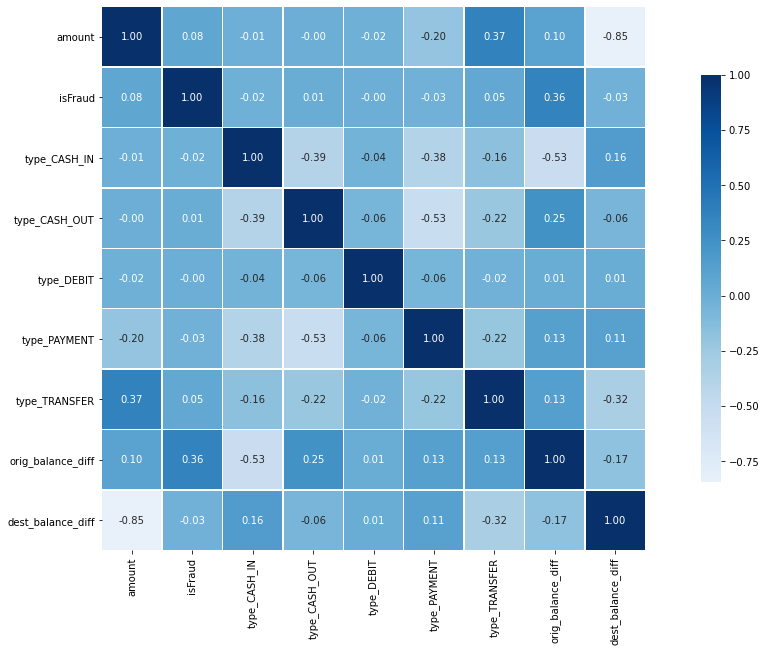

In [14]:
plt.figure(figsize = [20,10])  
sns.heatmap(data = data.corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  
          fmt='.2f',      
           cmap = 'Blues',   
           linewidths = .3,  
           cbar_kws={"shrink": .75})

In [15]:
%%time
# plot feature importance
from xgboost import XGBClassifier
from xgboost import plot_importance

plt.figure(figsize = [100,20])

X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

model = XGBClassifier()
model.fit(X, y)

CPU times: user 10min 6s, sys: 31.7 s, total: 10min 38s
Wall time: 1min 22s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

<Figure size 7200x1440 with 0 Axes>

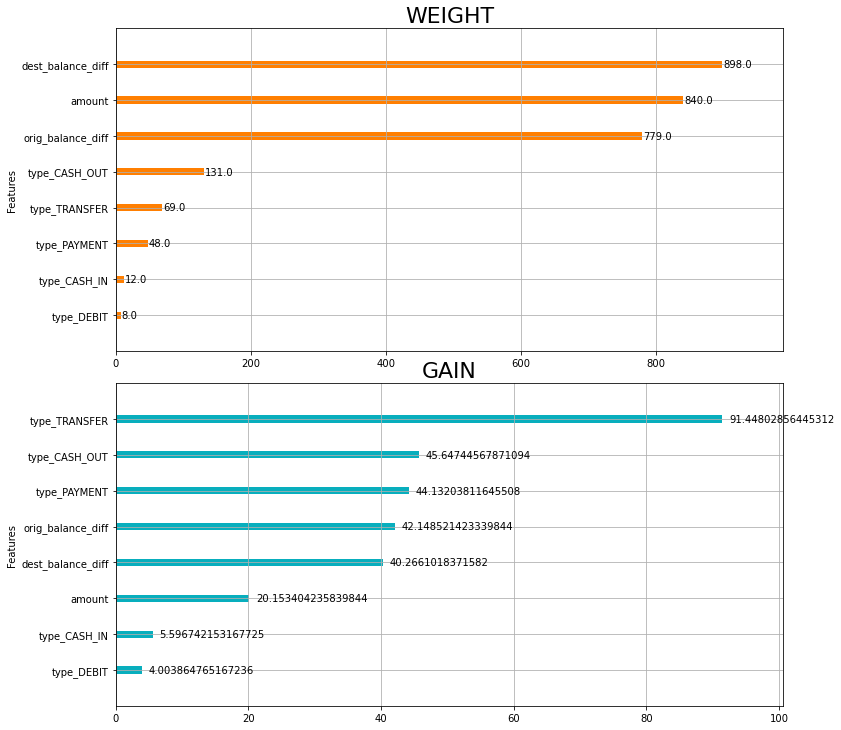

In [16]:
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain']
# loop through tickers and axes
colors = ['#ff7f01','#08aebd']
for ty, ax, color in zip(types, axs.ravel(), colors):
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

Combining the two plots above, we selected five important features.

In [17]:
data = data.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

### 3.2 Dask

In [18]:
data_dd = pd.read_csv('onlinefraud.csv')
data_dd = data_dd.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)
data_dd = from_pandas(data_dd, npartitions = 16)

In [19]:
data_dd

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
npartitions=16,,,,,,,
0,object,float64,float64,float64,float64,float64,int64
397664,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
5964960,...,...,...,...,...,...,...
6362619,...,...,...,...,...,...,...


In [20]:
%%time
from dask_ml.preprocessing import DummyEncoder
# Generate an encoder. 
encoder = DummyEncoder()
# Categorize your columns.  
data_dd = data_dd.categorize(['type'])
# Fit the encoder 
data_dd = encoder.fit_transform(data_dd)

CPU times: user 1.68 s, sys: 343 ms, total: 2.02 s
Wall time: 2.17 s


In [21]:
%%time
# Add two new features: the difference between the old balance and the new balance
data_dd['orig_balance_diff'] = data_dd.oldbalanceOrg - data_dd.newbalanceOrig
data_dd['dest_balance_diff'] = data_dd.oldbalanceDest - data_dd.newbalanceDest
data_dd = data_dd.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)

CPU times: user 24.3 ms, sys: 2.12 ms, total: 26.4 ms
Wall time: 23 ms


In [22]:
data_dd = data_dd.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

# 4. Handling unbalanced data

Not Fraud: 6354407
Is Fraud: 8213
Ratio: 773.7 : 1


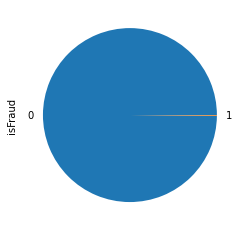

In [23]:
target_count = data.isFraud.value_counts()
print('Not Fraud:', target_count[0])
print('Is Fraud:', target_count[1])
print('Ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='pie');

The data is extremely unbalanced!, so try oversampling and undersampling!

### 4.1 pandas

#### 4.1.1 Oversampling

In [24]:
%%time
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsFraud_over = IsFraud.sample(IsNotFraud_count,replace=True)
over_balanced_data = pd.concat([IsNotFraud,IsFraud_over], axis=0)

CPU times: user 738 ms, sys: 970 ms, total: 1.71 s
Wall time: 1.71 s


Not Fraud: 6354407
Is Fraud: 6354407
Ratio: 1.0 : 1


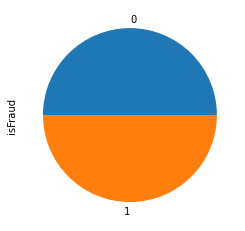

In [25]:
target_count = over_balanced_data.isFraud.value_counts()
print('Not Fraud:', target_count[0])
print('Is Fraud:', target_count[1])
print('Ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='pie');

#### 4.1.2 Undersampling

In [26]:
%%time
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data = pd.concat([IsNotFraud_under,IsFraud], axis=0)

CPU times: user 403 ms, sys: 223 ms, total: 627 ms
Wall time: 624 ms


Not Fraud: 6354
Is Fraud: 8213
Ratio: 0.77 : 1


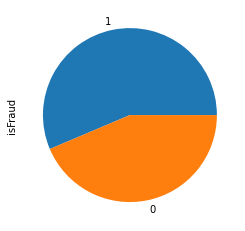

In [27]:
target_count = under_balanced_data.isFraud.value_counts()
print('Not Fraud:', target_count[0])
print('Is Fraud:', target_count[1])
print('Ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='pie');

### 4.2 Dask

#### 4.2.1 Oversampling

In [28]:
%%time
IsNotFraud_count,IsFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]

CPU times: user 2.51 s, sys: 878 ms, total: 3.39 s
Wall time: 1.93 s


In [29]:
IsFraud_over = IsFraud.sample(frac = 773.7,replace=True)
over_balanced_data_dd = dd.concat([IsNotFraud,IsFraud_over], axis=0)

Not Fraud: 6354407
Is Fraud: 6354397
Ratio: 1.0 : 1


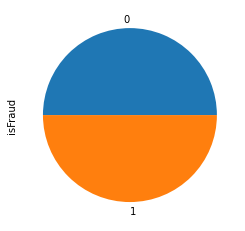

In [30]:
target_count = over_balanced_data_dd.compute().isFraud.value_counts()
print('Not Fraud:', target_count[0])
print('Is Fraud:', target_count[1])
print('Ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='pie');

In [31]:
X_over_balanced_data_dd = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y_over_balanced_data_dd = over_balanced_data_dd.loc[:,'isFraud'].values

In [32]:
X_over_balanced_data_dd.compute_chunk_sizes()

dask.array<values, shape=(12708804, 5), dtype=float64, chunksize=(2827100, 5), chunktype=numpy.ndarray>

In [33]:
y_over_balanced_data_dd.compute_chunk_sizes()

dask.array<values, shape=(12708804,), dtype=int64, chunksize=(2827100,), chunktype=numpy.ndarray>

#### 4.2.2 Undersampling

In [34]:
%%time
IsFraud_count, IsNotFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data_dd = dd.concat([IsNotFraud_under,IsFraud], axis=0)

CPU times: user 2.75 s, sys: 875 ms, total: 3.62 s
Wall time: 2.07 s


Not Fraud: 6351
Is Fraud: 8213
Ratio: 0.77 : 1


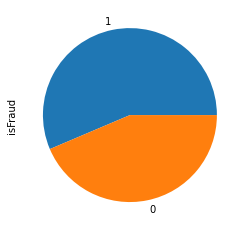

In [35]:
target_count = under_balanced_data_dd.compute().isFraud.value_counts()
print('Not Fraud:', target_count[0])
print('Is Fraud:', target_count[1])
print('Ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='pie');

In [36]:
X_under_balanced_data_dd = under_balanced_data_dd.iloc[:,under_balanced_data_dd.columns !='isFraud'].values
y_under_balanced_data_dd = under_balanced_data_dd.loc[:,'isFraud'].values

In [37]:
X_under_balanced_data_dd.compute_chunk_sizes()

dask.array<values, shape=(14564, 5), dtype=float64, chunksize=(3654, 5), chunktype=numpy.ndarray>

In [38]:
y_under_balanced_data_dd.compute_chunk_sizes()

dask.array<values, shape=(14564,), dtype=int64, chunksize=(3654,), chunktype=numpy.ndarray>